In [219]:
import cv2
from skimage import io
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageFilter
import numpy as np
import skimage.io
import skimage.color
import skimage.filters
from skimage.transform import (hough_line , hough_line_peaks)
from PIL import Image, ImageOps
from skimage.util import img_as_float
from skimage.util import img_as_ubyte
import numpy.ma as ma
from skimage.transform import probabilistic_hough_line

In [285]:
# Opening the image (R prefixed to string
# in order to deal with '\' in paths)
image_org = Image.open("goal.png")
# image_org = Image.open("6.jpg")
# image_org = Image.open("6.png")

# Converting the image to grayscale, as edge detection 
# requires input image to be of mode = Grayscale (L)
image = image_org.convert("L")
# image = ImageOps.invert(image)

# Detecting Edges on the Image using the argument ImageFilter.FIND_EDGES
# image = image.filter(ImageFilter.FIND_EDGES)
  
# Saving the Image Under the name Edge_Sample.png
# image.save(r"Edge_Sample.png")

In [73]:
def histogram_stretch(img_in):
    """
    Stretches the histogram of an image
    :param img_in: Input image
    :return: Image, where the histogram is stretched so the min values is 0 and the maximum value 255
    """
    # img_as_float will divide all pixel values with 255.0
    img_float = img_as_float(img_in)
    min_val = img_float.min()
    max_val = img_float.max()
    min_desired = 0.0
    max_desired = 1.0
    print(max_val)
    print(min_val)
    # Do something here
    img_out = (img_float-min_val)*(1/(max_val-min_val))
    # img_as_ubyte will multiply all pixel values with 255.0 before converting to unsigned byte
    return img_as_ubyte(img_out)

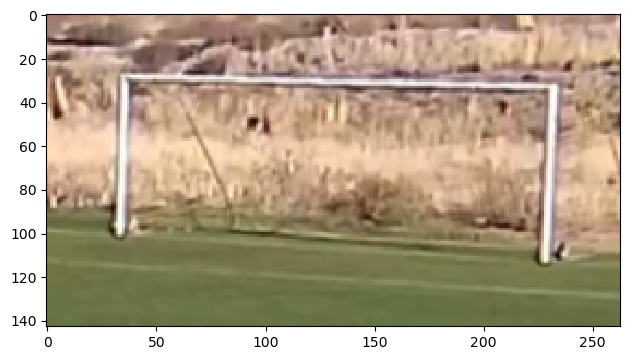

1.0
0.043137254901960784


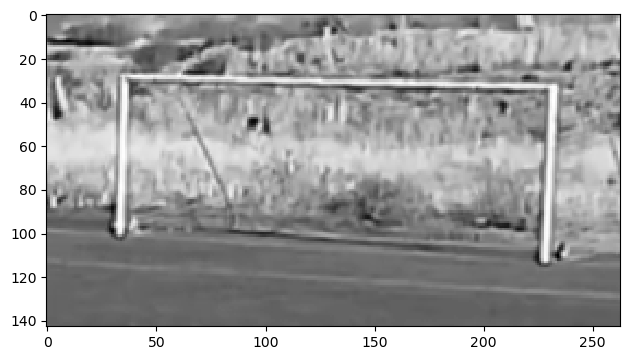

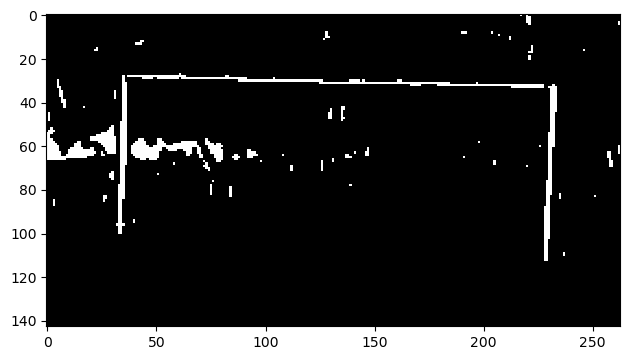

angle used: 1.5866629563584815
angle used: 0.06346651825433926
angle used: 3.173325912716963
angle used: 3.173325912716963
angle used: 4.6330558325667655
angle used: 1.4597299198498028
angle used: 4.759988869075444
angle used: 0.06346651825433926
[4.759988869075444]


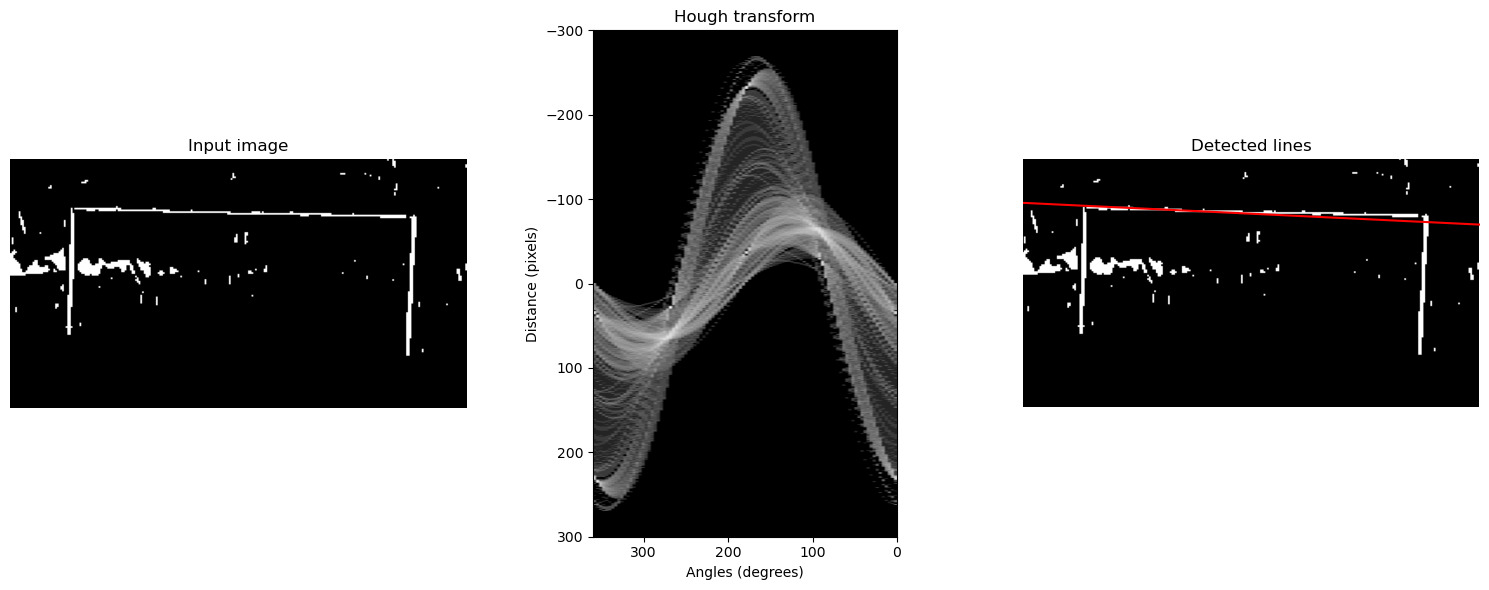

In [286]:
image1 = np.array(image)
image_org_1 = np.array(image_org)

# image1 = cv2.medianBlur(image1, 3)
io.imshow(image_org_1)
io.show()

image1 = histogram_stretch(image1)
# print(image1)

io.imshow(image1)
io.show()

ret,image1 = cv2.threshold(image1,220,255,cv2.THRESH_BINARY)
# ret, image1 = cv2.threshold(image1,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

io.imshow(image1)
io.show()



tested_angles = np.linspace( 0, 2*np.pi , 100)
# tested_angles_1 = np.linspace( , 2*np.pi , 100)


hspace, theta, dist = hough_line(image1, tested_angles)

# lines_prob = probabilistic_hough_line(image1, threshold=10, line_length=5,
                                #  line_gap=3)



# print("LINES: " ,lines)
# print((hspace).shape)
# print(theta)
# print(np.max(hspace))
h, q, d = hough_line_peaks(hspace, theta, dist)


#Example code from skimage documentation to plot the detected lines
angle_list=[]  #Create an empty list to capture all angles

# Generating figure 1
fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(image1, cmap='gray')
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(np.log(1 + hspace),
             extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), dist[-1], dist[0]],
             cmap='gray', aspect=1/1.5)
ax[1].set_title('Hough transform')
ax[1].set_xlabel('Angles (degrees)')
ax[1].set_ylabel('Distance (pixels)')
ax[1].axis('image')

ax[2].imshow(image1, cmap='gray')

origin = np.array((0, image1.shape[1]))

lines = 10
thres = 0.1

val= 3*np.pi/2

while (lines > 1):
    thres = thres + 0.02
    _, angle1, dist1 = hough_line_peaks(hspace, theta, dist, threshold = thres * np.max(hspace)) 
    arr = angle1[ (angle1 >= val-0.05) | (angle1 <= -val+0.05) ]
    arr2 = dist1[(angle1 >= val-0.05) | (angle1 <= -val+0.05)]
    lines = len(arr) 
    dist2 = np.unique(arr2)
    lines = len(dist2)
    # print("detected lines:",len(dist2)) 

# thres = 0.1


for _, angle, dist in zip(*hough_line_peaks(hspace, theta, dist, threshold = thres * np.max(hspace))):#, min_distance=110)):
    # if (angle<=-6.2) or (angle>=6.2) :
    print("angle used:", angle)
    # if (angle>=-val) & (angle<=val) :
    if ((angle>=val-0.05) & (angle<=val+0.05)):
    # if (angle>=-np.pi) & (angle<=val) :

        # print("angle used123:", angle)
        angle_list.append(angle) #Not for plotting but later calculation of angles
        y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
        # print("sth", x)
        # print("dist", dist)
        # print("origin", origin)
        # print("y0", y0)
        # print("y1", y1)
        ax[2].plot(origin, (y0, y1), '-r')
        # ax[2].plot(1, x, 'ob')
print(angle_list)
ax[2].set_xlim(origin)
ax[2].set_ylim((image1.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')

plt.tight_layout()
plt.show()

e:\anaconda\envs\lab4\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


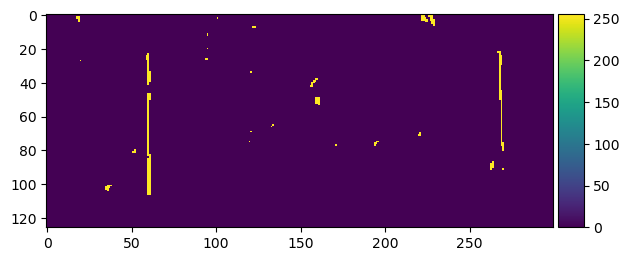

(126, 300)
(126, 300, 3)
lines not found


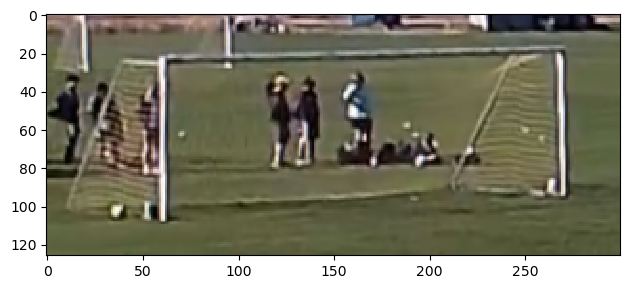

In [224]:
path = 'goal.png'

image1 = np.array(image)
image_org_1 = np.array(image_org)

# image1 = cv2.medianBlur(image1, 3)
ret,image1 = cv2.threshold(image1,227,255,cv2.THRESH_BINARY)
io.imshow(image1)
io.show()

# lines = cv2.HoughLinesP(image1, 1, np.pi/180, 100, minLineLength=10, maxLineGap=250)
lines = cv2.HoughLinesP(image1,1,2,250,minLineLength=10,maxLineGap=30)
minLineLength=100
# lines = cv2.HoughLinesP(image=image1,rho=1,theta=np.pi/180, threshold=100,lines=np.array([]), minLineLength=minLineLength,maxLineGap=80)
print(image1.shape)
print(image_org_1.shape)
# lines = cv2.HoughLinesP(image1, 2, np.pi/180, 350, np.array([]), minLineLength=100, maxLineGap=5)
if(lines):
    print(len(lines))
    print(lines)
else: 
    print("lines not found")

threshold = -350
error = 10
    # Draw the lines
   
if lines is not None:
    for i in range(0, len(lines)):
        l = lines[i][0]
        angle = math.atan2(l[3] - l[1], l[2] - l[0]) * 180.0
        if angle>threshold: 
            print(angle)
            cv2.line(image_org_1, (l[0], l[1]), (l[2], l[3]), (0,0,255), 1, cv2.LINE_AA)

io.imshow(image_org_1)
io.show()

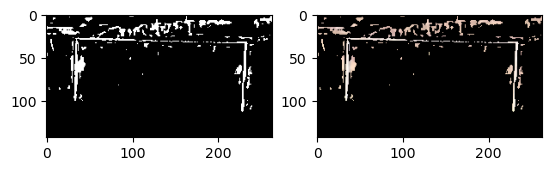

In [73]:
nemo = cv2.imread('goal.png')
nemo = cv2.cvtColor(nemo, cv2.COLOR_BGR2RGB)
hsv_nemo = cv2.cvtColor(nemo, cv2.COLOR_RGB2HSV)
light_white = (0, 0, 200)
dark_white = (145, 60, 255)
mask_white = cv2.inRange(hsv_nemo, light_white, dark_white)
result_white = cv2.bitwise_and(nemo, nemo, mask=mask_white)

plt.subplot(1, 2, 1)
plt.imshow(mask_white, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result_white)
plt.show()